<a href="https://colab.research.google.com/github/HakureiPOI/Modeling_Allowance/blob/main/MonteCarloGradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [2]:
# 定义目标函数（Rastrigin 函数）
def rastrigin_function(x):
    """
    Rastrigin 函数
    :param x: 输入变量 (张量)
    :return: 函数值 (标量)
    """
    n = len(x)
    return 10 * n + torch.sum(x**2 - 10 * torch.cos(2 * torch.pi * x))

class MonteCarloGradientDescent:
    def __init__(self, obj_function, dim, bounds, lr=0.01, max_iter=200, num_starts=50, patience=30, lr_decay=0.95):
        """
        蒙特卡洛随机初始化 + 梯度下降优化器 (带早停机制和学习率调度)
        :param obj_function: 目标函数
        :param dim: 问题维度
        :param bounds: 每个维度的边界 [(lower, upper), ...]
        :param lr: 初始学习率
        :param max_iter: 每次梯度下降的最大迭代次数
        :param num_starts: 随机初始化点的数量
        :param patience: 早停机制的容忍次数
        :param lr_decay: 学习率的衰减因子
        """
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = torch.tensor(bounds)
        self.lr = lr
        self.max_iter = max_iter
        self.num_starts = num_starts
        self.patience = patience
        self.lr_decay = lr_decay
        self.best_score = float('inf')
        self.best_position = None
        self.results = []  # 保存每次优化的结果

    def standardize(self, x):
        """
        将输入标准化到 [0, 1] 区间
        :param x: 输入张量
        :return: 标准化后的张量
        """
        return (x - self.bounds[:, 0]) / (self.bounds[:, 1] - self.bounds[:, 0])

    def destandardize(self, x):
        """
        将 [0, 1] 标准化数据还原到原始范围
        :param x: 标准化张量
        :return: 还原后的张量
        """
        return x * (self.bounds[:, 1] - self.bounds[:, 0]) + self.bounds[:, 0]

    def optimize_single(self, init_position):
        """
        对单个初始点执行梯度下降优化，带早停机制和动态学习率
        :param init_position: 初始位置 (张量)
        :return: 优化后的参数位置 (numpy数组), 优化前的函数值, 优化后的函数值
        """
        # 标准化初始位置
        init_position = self.standardize(init_position)
        params = torch.nn.Parameter(init_position)
        optimizer = optim.Adam([params], lr=self.lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.lr_decay)  # 学习率衰减
        initial_fitness = self.obj_function(self.destandardize(params)).item()  # 初始适应度
        best_loss = float('inf')
        no_improve_count = 0

        for _ in range(self.max_iter):
            optimizer.zero_grad()
            # 目标函数在还原到原始范围后计算
            loss = self.obj_function(self.destandardize(params))
            loss.backward()
            optimizer.step()
            scheduler.step()  # 更新学习率

            # 确保标准化范围在 [0, 1] 内
            with torch.no_grad():
                params.clamp_(0, 1)

            # 检测改进情况
            if loss.item() < best_loss:
                best_loss = loss.item()
                no_improve_count = 0  # 重置早停计数器
            else:
                no_improve_count += 1

            # 提前停止
            if no_improve_count >= self.patience:
                break

        # 将最终参数还原到原始范围
        return self.destandardize(params).detach().numpy(), initial_fitness, best_loss

    def optimize(self):
        """
        执行蒙特卡洛随机初始化 + 梯度下降优化 (支持并行化)
        """
        # 定义并行任务
        def task(start_idx):
            # 随机初始化点
            init_position = torch.rand(self.dim) * (self.bounds[:, 1] - self.bounds[:, 0]) + self.bounds[:, 0]
            final_position, initial_fitness, final_fitness = self.optimize_single(init_position)
            print(f"Start {start_idx + 1}/{self.num_starts}: Initial Fitness = {initial_fitness:.4f}, Final Fitness = {final_fitness:.4f}")
            return final_position, initial_fitness, final_fitness

        # 并行执行
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(task, i) for i in range(self.num_starts)]
            for future in futures:
                position, initial_fitness, final_fitness = future.result()
                self.results.append((position, initial_fitness, final_fitness))
                if final_fitness < self.best_score:
                    self.best_score = final_fitness
                    self.best_position = position

        return self.best_position, self.best_score

    def visualize_results(self):
        """
        使用 Seaborn 可视化优化前后适应度的对比
        """
        initial_scores = [result[1] for result in self.results]
        final_scores = [result[2] for result in self.results]

        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        sns.histplot(initial_scores, bins=20, kde=True, color="red", alpha=0.6, label="Initial Fitness")
        sns.histplot(final_scores, bins=20, kde=True, color="blue", alpha=0.6, label="Final Fitness")
        plt.title("Fitness Before and After Optimization", fontsize=16)
        plt.xlabel("Fitness Value", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(visible=True)
        plt.show()

        print(f"Best Final Fitness Value: {self.best_score}")

In [3]:
# 定义目标函数（Rastrigin 函数）
def rastrigin_function(x):
    """
    Rastrigin 函数
    :param x: 输入变量 (张量)
    :return: 函数值 (标量)
    """
    n = len(x)
    return 10 * n + torch.sum(x**2 - 10 * torch.cos(2 * torch.pi * x))

In [4]:
# 参数设置
DIM = 10                        # 问题维度
BOUNDS = [(-5.12, 5.12)] * DIM  # 定义域
LR = 0.01                       # 初始学习率
MAX_ITER = 300                  # 每次梯度下降的最大迭代次数
NUM_STARTS = 500                # 随机初始化点数量
PATIENCE = 30                   # 早停机制的容忍次数
LR_DECAY = 0.95                 # 学习率衰减因子

In [5]:
# 执行优化
optimizer = MonteCarloGradientDescent(
    obj_function=rastrigin_function,
    dim=DIM,
    bounds=BOUNDS,
    lr=LR,
    max_iter=MAX_ITER,
    num_starts=NUM_STARTS,
    patience=PATIENCE,
    lr_decay=LR_DECAY
)

In [6]:
best_position, best_score = optimizer.optimize()

Start 4/500: Initial Fitness = 251.6152, Final Fitness = 123.3745
Start 2/500: Initial Fitness = 167.2756, Final Fitness = 106.4600
Start 3/500: Initial Fitness = 221.5576, Final Fitness = 114.4200
Start 6/500: Initial Fitness = 168.5230, Final Fitness = 44.7735
Start 1/500: Initial Fitness = 163.8887, Final Fitness = 61.6875
Start 5/500: Initial Fitness = 210.1372, Final Fitness = 109.4451
Start 9/500: Initial Fitness = 250.1530, Final Fitness = 112.4297
Start 8/500: Initial Fitness = 237.3288, Final Fitness = 136.3085
Start 7/500: Initial Fitness = 138.6552, Final Fitness = 60.6925
Start 10/500: Initial Fitness = 175.9391, Final Fitness = 93.5257
Start 11/500: Initial Fitness = 125.8928, Final Fitness = 46.7633
Start 12/500: Initial Fitness = 177.5676, Final Fitness = 71.6370
Start 14/500: Initial Fitness = 146.2822, Final Fitness = 79.5964
Start 13/500: Initial Fitness = 127.4097, Final Fitness = 50.7430
Start 16/500: Initial Fitness = 177.9812, Final Fitness = 112.4297
Start 15/500

In [7]:
print(f"最优位置: {best_position}")
print(f"最优适应度: {best_score}")

最优位置: [-9.9566031e-01  9.9492359e-01  9.9436092e-01  3.9797678e+00
  9.9451160e-01  1.9902811e+00  6.1988831e-06  9.9547529e-01
  9.9528980e-01 -9.9435711e-01]
最优适应度: 26.864166259765625


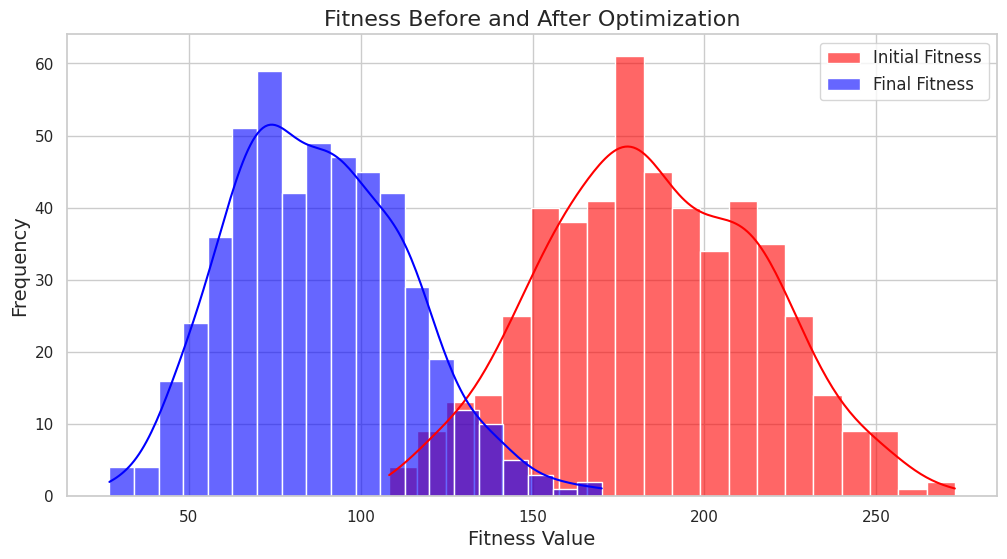

Best Final Fitness Value: 26.864166259765625


In [8]:
# 可视化优化前后适应度分布
optimizer.visualize_results()